In [2]:
# learning from here: https://pyfai.readthedocs.io/en/latest/usage/tutorial/Introduction/introduction.html

import os, time
#Nota: comment out when outside ESRF
# os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"
start_time = time.time()
import pyFAI
print("Using pyFAI version", pyFAI.version)

from silx.resources import ExternalResources
downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/testimages/", "DATA")

moke = downloader.getfile("moke.tif")
print(moke)

#initializes the visualization module to work with the jupyter notebook
%pylab nbagg

Using pyFAI version 0.15.0
/tmp/pyFAI_testdata_mt/moke.tif
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


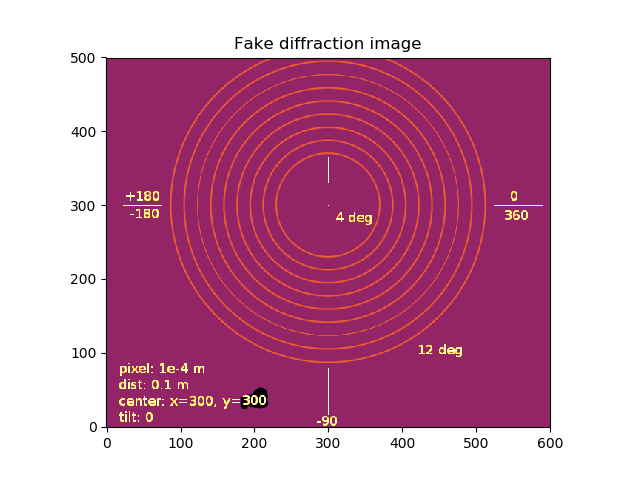

In [3]:
import fabio
from pyFAI.gui import jupyter
img = fabio.open(moke).data
jupyter.display(img, label ="Fake diffraction image")

<IPython.core.display.Javascript object>


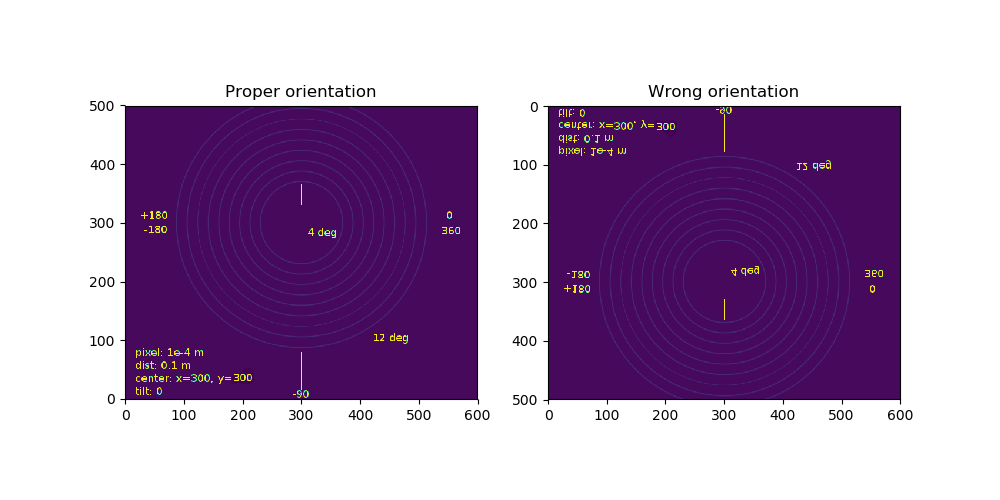

In [4]:
fig, ax = subplots(1,2, figsize=(10,5))
ax[0].imshow(img, origin="lower")
ax[0].set_title("Proper orientation")
ax[1].imshow(img)
ax[1].set_title("Wrong orientation");

In [5]:
import pyFAI
detector = pyFAI.detectors.Detector(pixel1=1e-4, pixel2=1e-4)
ai = pyFAI.AzimuthalIntegrator(dist=0.1, detector=detector)
# Short version ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
print(ai)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
SampleDetDist= 1.000000e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 100.000mm	Center: x=0.000, y=0.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


In [6]:
help(ai.setFit2D)

Help on method setFit2D in module pyFAI.geometry:

setFit2D(directDist, centerX, centerY, tilt=0.0, tiltPlanRotation=0.0, pixelX=None, pixelY=None, splineFile=None) method of pyFAI.azimuthalIntegrator.AzimuthalIntegrator instance
    Set the Fit2D-like parameter set: For geometry description see
    HPR 1996 (14) pp-240
    
    By reverse engineering we noticed this behavour for Tiff and Mar345 images (at least).
    To obtaine correct result you will have to flip images using numpy.flipud.
    
    :param direct: direct distance from sample to detector along the incident beam (in millimeter as in fit2d)
    :param tilt: tilt in degrees
    :param tiltPlanRotation: Rotation (in degrees) of the tilt plan arround the Z-detector axis
            * 0deg -> Y does not move, +X goes to Z<0
            * 90deg -> X does not move, +Y goes to Z<0
            * 180deg -> Y does not move, +X goes to Z>0
            * 270deg -> X does not move, +Y goes to Z>0
    
    :param pixelX,pixelY: as in 

<IPython.core.display.Javascript object>


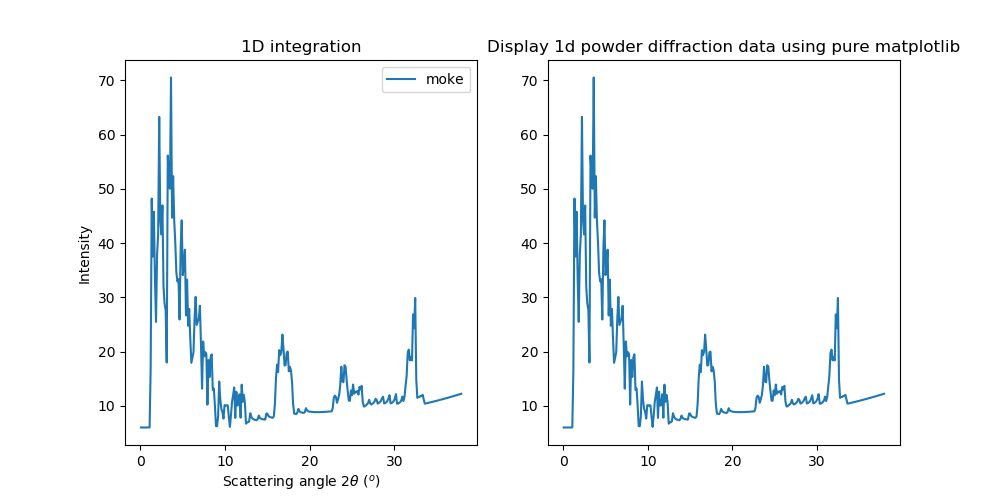

Text(0.5,1,'Display 1d powder diffraction data using pure matplotlib')

In [7]:

res = ai.integrate1d(img, 300, unit="2th_deg")

#Display the integration result
fig, ax = subplots(1,2, figsize=(10,5))
jupyter.plot1d(res, label="moke",ax=ax[0])

#Example using pure matplotlib
tth = res[0]
I = res[1]
ax[1].plot(tth, I, label="moke")
ax[1].set_title("Display 1d powder diffraction data using pure matplotlib")

In [8]:
ai.integrate1d(img, 30, unit="2th_deg", filename="moke.dat")

# now display the content of the file
with open("moke.dat") as fd:
    for line in fd:
        print(line.strip())

# == pyFAI calibration ==
# Distance Sample to Detector: 0.1 m
# PONI: 0.000e+00, 0.000e+00 m
# Rotations: 0.000000 0.000000 0.000000 rad
#
# == Fit2d calibration ==
# Distance Sample-beamCenter: 100.000 mm
# Center: x=0.000, y=0.000 pix
# Tilt: 0.000 deg  TiltPlanRot: 0.000 deg
#
# Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
#    Detector has a mask: False
#    Detector has a dark current: False
#    detector has a flat field: False
#
# Mask applied: False
# Dark current applied: False
# Flat field applied: False
# Polarization factor: None
# Normalization factor: 1.0
# --> moke.dat
#       2th_deg             I
6.331790e-01    8.040550e+00
1.899537e+00    4.227679e+01
3.165895e+00    4.360847e+01
4.432253e+00    3.776727e+01
5.698611e+00    2.623081e+01
6.964969e+00    2.346836e+01
8.231327e+00    1.570432e+01
9.497685e+00    9.263981e+00
1.076404e+01    9.935521e+00
1.203040e+01    1.006979e+01
1.329676e+01    7.570359e+00
1.456312e+01    7.886490e+00
1.582947

<IPython.core.display.Javascript object>


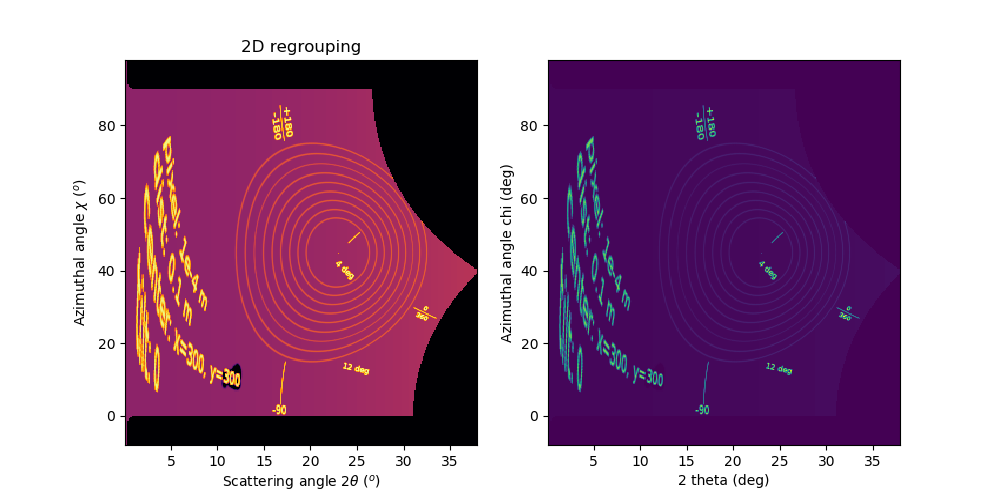

Text(0,0.5,'Azimuthal angle chi (deg)')

In [9]:
res2d = ai.integrate2d(img, 300, 360, unit="2th_deg")

#Display the integration result
fig, ax = subplots(1,2, figsize=(10,5))
jupyter.plot2d(res2d, label="moke",ax=ax[0])

#Example using pure matplotlib
I, tth, chi = res2d
ax[1].imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto")
ax[1].set_xlabel("2 theta (deg)")
ax[1].set_ylabel("Azimuthal angle chi (deg)")

Column number 21


<IPython.core.display.Javascript object>


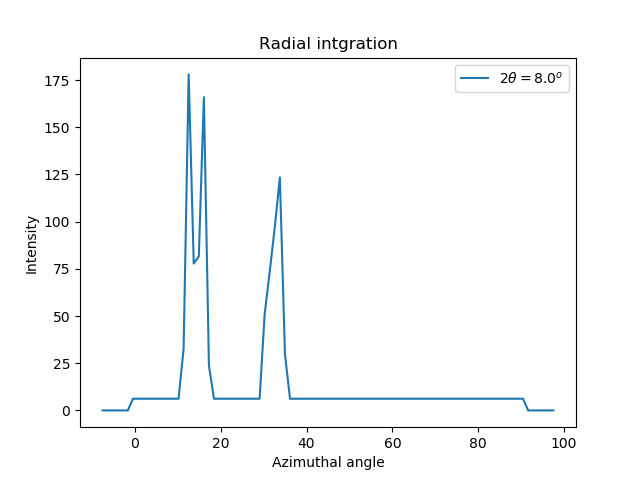

In [10]:
target = 8 #degrees
#work on fewer radial bins in order to have an actual averaging:
I, tth, chi = ai.integrate2d(img, 100, 90, unit="2th_deg")
column = argmin(abs(tth-target))
print("Column number %s"%column)

fig, ax = subplots()
ax.plot(chi, I[:,column], label=r"$2\theta=%.1f^{o}$"%target)
ax.set_xlabel("Azimuthal angle")
ax.set_ylabel("Intensity")
ax.set_title("Radial intgration")
ax.legend()